In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-s94vl_ut
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-s94vl_ut
  Resolved https://github.com/google-research/timesfm to commit d92687f8a3a3b2469c54af1c493969220a86bec4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 12

In [2]:
!pip install yfinance
!pip install utilsforecast


# get 3 years forcast 10 day next

In [1]:
import yfinance as yf

# Fetch historical data for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Display the first few rows of the dataset
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960480  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251137  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826836  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200


In [2]:
import pandas as pd

# Select the 'Close' price as the feature for forecasting
data = data[['Close']]

# Reset index to use the date in the DataFrame
data.reset_index(inplace=True)

# Rename columns to match expected format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'  # Add a unique_id column

print(data.head())


          ds          y unique_id
0 2020-01-02  75.087502      AAPL
1 2020-01-03  74.357498      AAPL
2 2020-01-06  74.949997      AAPL
3 2020-01-07  74.597504      AAPL
4 2020-01-08  75.797501      AAPL


<ipython-input-2-637f45bdc8c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
<ipython-input-2-637f45bdc8c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['unique_id'] = 'AAPL'  # Add a unique_id column


In [3]:
# Split into training and test sets
train_data = data[data['ds'] < '2023-12-22']
test_data = data[data['ds'] >= '2023-12-22']

print("Training data:")
print(train_data.tail())
print("Test data:")
print(test_data.head())


Training data:
             ds           y unique_id
996  2023-12-15  197.570007      AAPL
997  2023-12-18  195.889999      AAPL
998  2023-12-19  196.940002      AAPL
999  2023-12-20  194.830002      AAPL
1000 2023-12-21  194.679993      AAPL
Test data:
             ds           y unique_id
1001 2023-12-22  193.600006      AAPL
1002 2023-12-26  193.050003      AAPL
1003 2023-12-27  193.149994      AAPL
1004 2023-12-28  193.580002      AAPL
1005 2023-12-29  192.529999      AAPL


In [4]:
import timesfm

# Initialize the model
tfm = timesfm.TimesFm(
    context_len=512,  # Maximum context length
    horizon_len=10,  # Forecasting the next 10 days
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',  # Or 'jax'
)

# Load the pretrained model
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Perform inference on the training set to predict the test set
forecast_df = tfm.forecast_on_df(
    inputs=train_data,
    freq="D",
    value_name="y",
    num_jobs=-1,
)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.17 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.95 seconds.
Jitting decoding.
Jitted decoding in 23.84 seconds.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [5]:
print(forecast_df.head(10))

  unique_id         ds     timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0      AAPL 2023-12-22  194.539246     190.541504     191.847137   
1      AAPL 2023-12-23  194.267654     188.924255     190.894379   
2      AAPL 2023-12-24  194.099487     187.640015     190.324554   
3      AAPL 2023-12-25  194.015656     186.286545     188.944901   
4      AAPL 2023-12-26  193.503815     184.804214     187.847168   
5      AAPL 2023-12-27  193.946136     184.271667     187.586960   
6      AAPL 2023-12-28  193.312897     183.192734     186.945068   
7      AAPL 2023-12-29  193.514664     182.654327     186.643173   
8      AAPL 2023-12-30  193.294678     181.520630     185.751572   
9      AAPL 2023-12-31  193.111084     180.972580     185.263763   

   timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  timesfm-q-0.7  \
0     192.906006     193.696640     194.539246     195.032318     195.863037   
1     192.468979     193.418961     194.267654     195.207657     196.258636   
2     191.7

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_df = forecast_df[['ds', 'timesfm']]
forecast_df.rename(columns={'timesfm': 'y_predicted'}, inplace=True)
test_data = test_data[['ds', 'y']]
merged_df = pd.merge(test_data, forecast_df, on='ds')

# Step 6: Calculate Loss Metrics
mse = mean_squared_error(merged_df['y'], merged_df['y_predicted'])
mae = mean_absolute_error(merged_df['y'], merged_df['y_predicted'])

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 0.5525737981777639
Mean Absolute Error: 0.6881927490234375


<ipython-input-6-590fa2e84a59>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df.rename(columns={'timesfm': 'y_predicted'}, inplace=True)


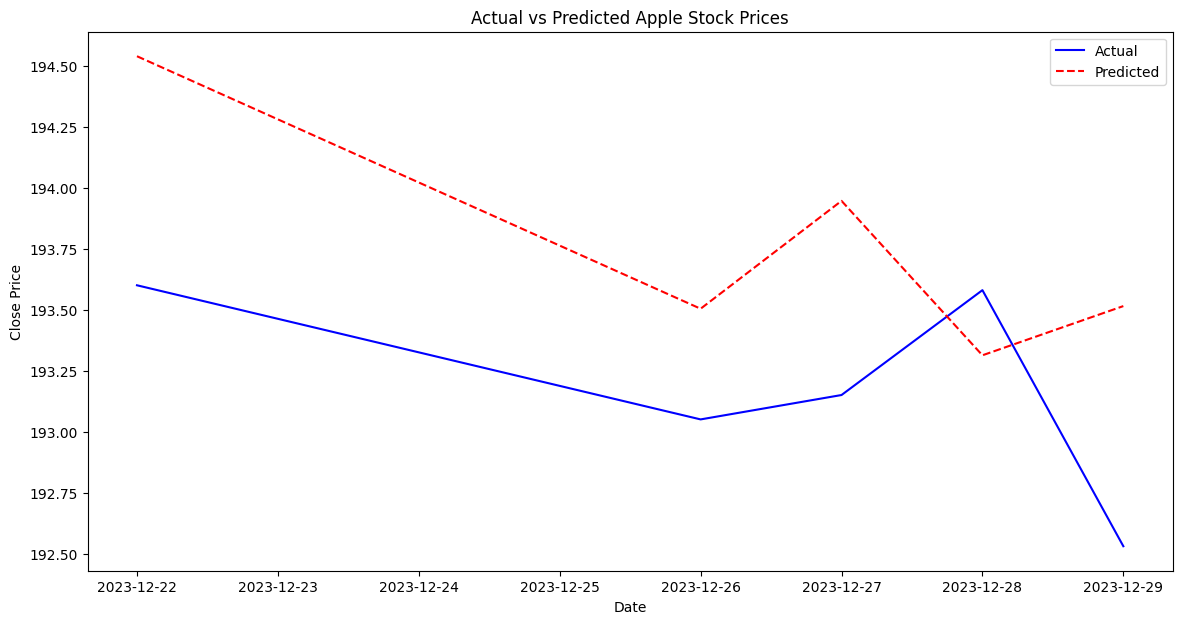

In [7]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(merged_df['ds'], merged_df['y'], label='Actual', color='blue')
plt.plot(merged_df['ds'], merged_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.legend()
plt.show()


Total Profit: -0.49 USD
          ds           y  y_predicted signal     capital
0 2023-12-22  193.600006   194.539246   Sell  100.000000
1 2023-12-26  193.050003   193.503815    Buy  100.000000
2 2023-12-27  193.149994   193.946136   Sell  100.051795
3 2023-12-28  193.580002   193.312897    Buy  100.051795
4 2023-12-29  192.529999   193.514664   Sell   99.509101


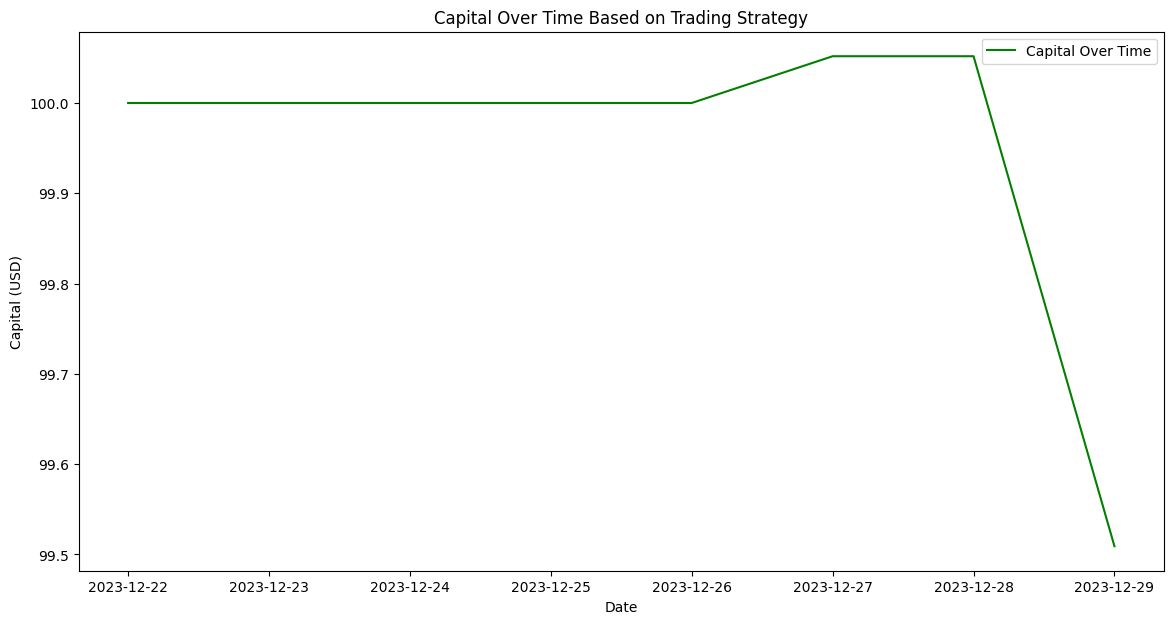

In [10]:
import numpy as np

# ایجاد سیگنال‌های خرید و فروش
merged_df['signal'] = np.where(merged_df['y_predicted'].shift(-1) > merged_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []

# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(merged_df) - 1):
    if merged_df.loc[i, 'signal'] == 'Buy':
        # خرید سهام با تمام سرمایه
        shares = capital / merged_df.loc[i, 'y']
        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif merged_df.loc[i, 'signal'] == 'Sell' and shares > 0:
        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * merged_df.loc[i, 'y']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * merged_df.loc[i, 'y'])

# محاسبه سود نهایی
final_capital = capital + shares * merged_df.iloc[-1]['y']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# نمایش سیگنال‌ها و سود هر روز
merged_df['capital'] = capital_history + [final_capital]
print(merged_df[['ds', 'y', 'y_predicted', 'signal', 'capital']])

# رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(merged_df['ds'], merged_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# forecast next day by one month

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import timesfm
import numpy as np

# Fetch historical data for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Select the 'Close' price as the feature for forecasting
data = data[['Close']]

# Reset index to use the date in the DataFrame
data.reset_index(inplace=True)

# Rename columns to match expected format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'  # Add a unique_id column

# Initialize the model
tfm = timesfm.TimesFm(
    context_len=512,  # Maximum context length
    horizon_len=1,  # Forecasting the next day
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',  # Or 'jax'
)

# Load the pretrained model
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Function to predict the next day
def predict_next_day(train_data):
    forecast_df = tfm.forecast_on_df(
        inputs=train_data,
        freq="D",
        value_name="y",
        num_jobs=-1,
    )
    print('forecast_df.iloc[-1]',forecast_df)
    return forecast_df.iloc[-1]['timesfm']

# Splitting the data into rolling windows
start_date = '2023-01-01'
end_date = '2023-12-31'
window_size = 30

results = []

date_range = pd.date_range(start=start_date, end=end_date)

for i in range(len(date_range) - window_size):
    train_window_start = date_range[i]
    train_window_end = date_range[i + window_size - 1]
    predict_date = date_range[i + window_size]
    print('train_window_start',train_window_start,'train_window_end',train_window_end,'predict_date',predict_date)

    train_data = data[(data['ds'] >= train_window_start) & (data['ds'] <= train_window_end)]
    print('train_data',train_data)
    if predict_date not in data['ds'].values:
      print(f"Skipping prediction for {predict_date} as it's not in the data.")
      continue

    actual_value = data[data['ds'] == predict_date]['y'].values


    predicted_value = predict_next_day(train_data)
    results.append({'ds': predict_date, 'y_actual': actual_value[0], 'y_predicted': predicted_value})



In [ ]:
len(results)

In [ ]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV file
results_df.to_csv('one_month_input_one_dY.csv', index=False)

print("Results saved to prediction_results.csv")


Results saved to prediction_results.csv


In [60]:
results_df=pd.read_csv('/content/one_month_input_one_dY.csv',)
results_df

,ds,y_actual,y_predicted
0,2023-01-31,144.289993,140.42755
1,2023-02-01,145.429993,143.24666
2,2023-02-02,150.820007,145.26890
3,2023-02-03,154.500000,149.06754
4,2023-02-06,151.729996,153.91434
...,...,...,...
226,2023-12-22,193.600006,193.98984
227,2023-12-26,193.050003,193.25229
228,2023-12-27,193.149994,192.46585
229,2023-12-28,193.580002,192.46298


Overall Mean Squared Error: 7.127781104585507
Overall Mean Absolute Error: 2.090915224482548


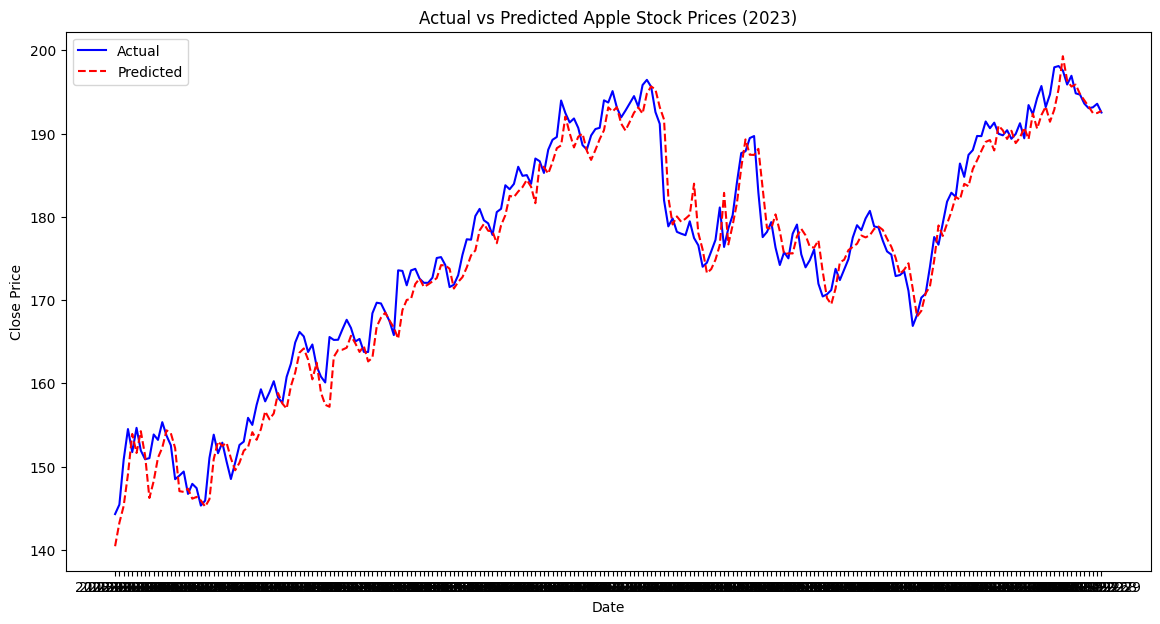

In [61]:


# Calculate overall accuracy
mse = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
mae = mean_absolute_error(results_df['y_actual'], results_df['y_predicted'])

print(f'Overall Mean Squared Error: {mse}')
print(f'Overall Mean Absolute Error: {mae}')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Apple Stock Prices (2023)')
plt.legend()
plt.show()

MSE for the predictive model: 7.127781104585507
MSE for the naive prediction: 4.608868222595602


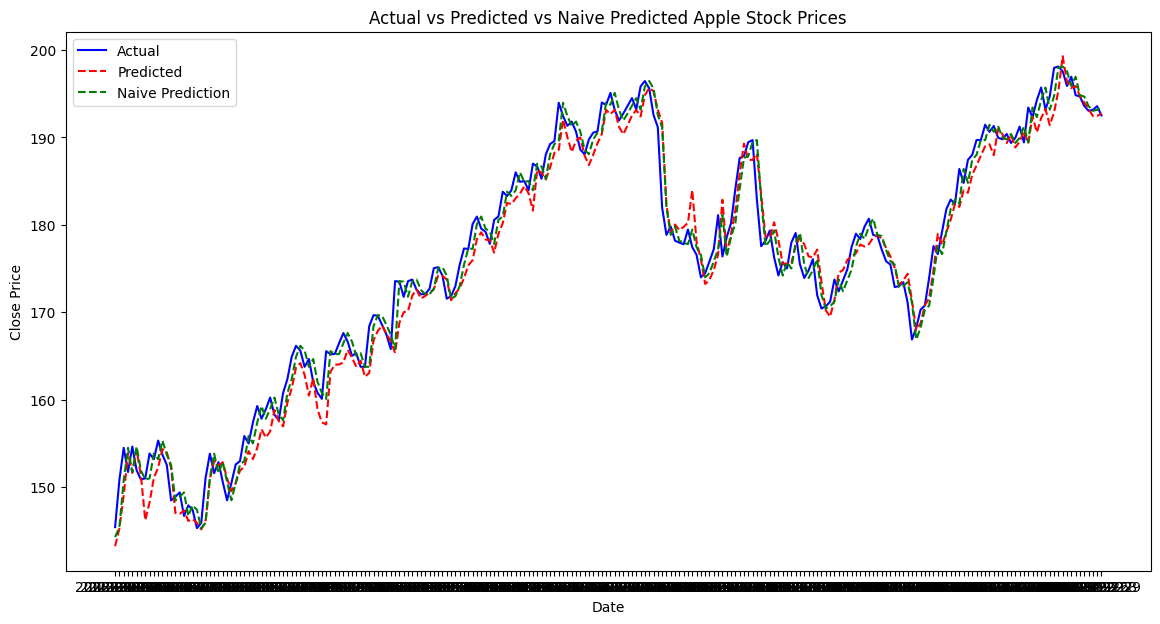

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
print(f'MSE for the predictive model: {mse_model}')

# محاسبه MSE برای پیش‌بینی ناهموار (فرض می‌کنیم قیمت فردا برابر با قیمت امروز است)
results_df['y_naive'] = results_df['y_actual'].shift(1)  # قیمت ناهموار
results_df.dropna(inplace=True)


mse_naive = mean_squared_error(results_df['y_actual'], results_df['y_naive'])
print(f'MSE for the naive prediction: {mse_naive}')

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.plot(results_df['ds'], results_df['y_naive'], label='Naive Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted vs Naive Predicted Apple Stock Prices')
plt.legend()
plt.show()


In [63]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['ds']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['ds']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.4388888888888889


In [64]:
total_predictions

180

In [66]:
results_df

,ds,y_actual,y_predicted,y_naive,signal
1,2023-02-01,145.429993,143.24666,144.289993,Buy
2,2023-02-02,150.820007,145.26890,145.429993,Buy
3,2023-02-03,154.500000,149.06754,150.820007,Buy
4,2023-02-06,151.729996,153.91434,154.500000,Sell
5,2023-02-07,154.649994,151.62733,151.729996,Buy
...,...,...,...,...,...
226,2023-12-22,193.600006,193.98984,194.679993,Sell
227,2023-12-26,193.050003,193.25229,193.600006,Sell
228,2023-12-27,193.149994,192.46585,193.050003,Sell
229,2023-12-28,193.580002,192.46298,193.149994,Buy


# buy and sell all

Total Profit: 25.80 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  103.706261
3    2023-02-03  154.500000    149.06754    Buy  106.236683
4    2023-02-06  151.729996    153.91434   Sell  104.331983
5    2023-02-07  154.649994    151.62733    Buy  104.331983
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  126.490572
227  2023-12-26  193.050003    193.25229   Sell  126.490572
228  2023-12-27  193.149994    192.46585   Sell  126.490572
229  2023-12-28  193.580002    192.46298    Buy  126.490572
230  2023-12-29  192.529999    192.72406   Sell  125.804470

[230 rows x 5 columns]


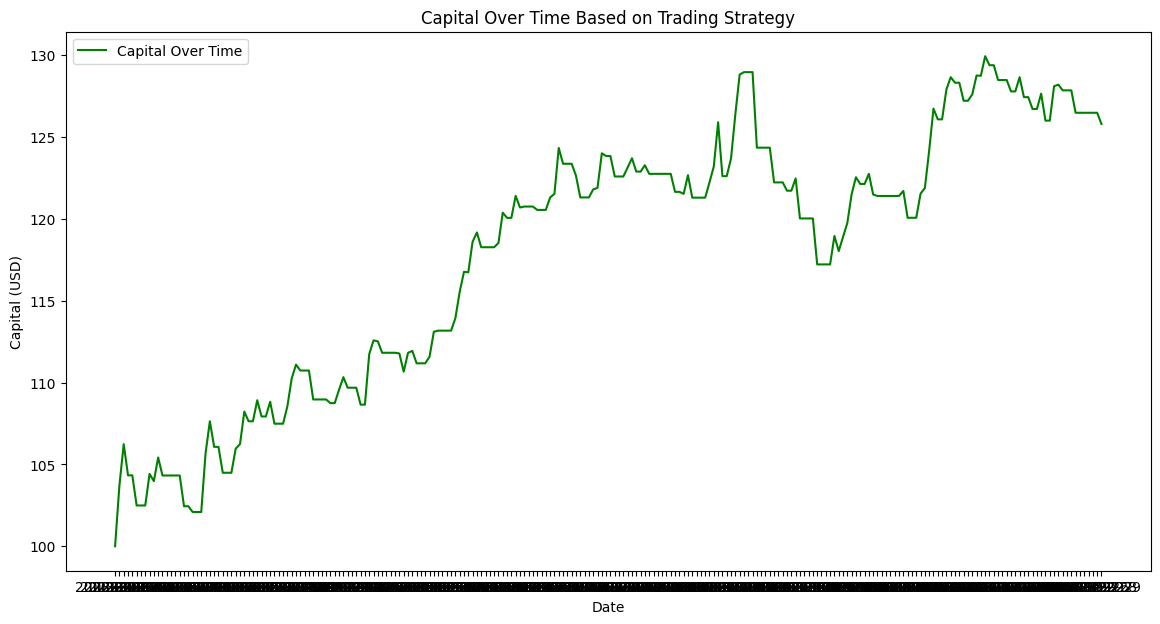

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# y_naive

Total Profit: 19.88 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  103.706261
3    2023-02-03  154.500000    149.06754    Buy  106.236683
4    2023-02-06  151.729996    153.91434   Sell  104.331983
5    2023-02-07  154.649994    151.62733    Buy  104.331983
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  120.265331
227  2023-12-26  193.050003    193.25229   Sell  120.265331
228  2023-12-27  193.149994    192.46585    Buy  120.265331
229  2023-12-28  193.580002    192.46298    Buy  120.533076
230  2023-12-29  192.529999    192.72406   Sell  119.879289

[230 rows x 5 columns]


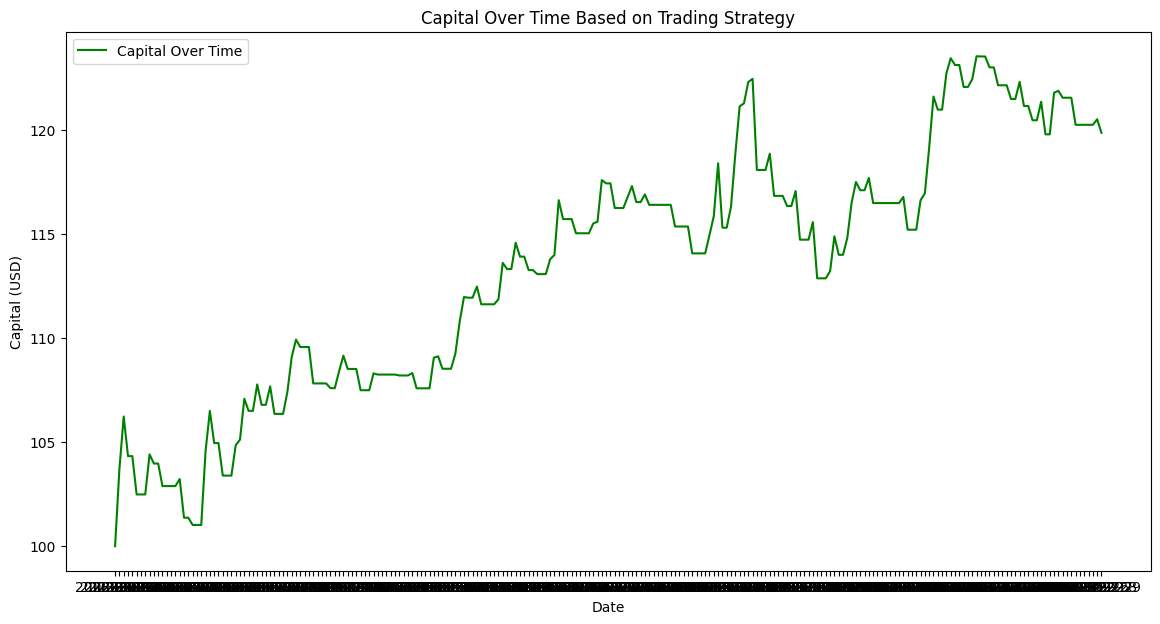

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_naive'].shift(-1) > results_df['y_naive'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []


# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# buy with fraction sell all

Total Profit: 20.59 USD
             ds    y_actual  y_predicted signal     capital
0    2023-01-31  144.289993    140.42755    Buy  100.000000
1    2023-02-01  145.429993    143.24666    Buy  100.395038
2    2023-02-02  150.820007    145.26890    Buy  103.189374
3    2023-02-03  154.500000    149.06754    Buy  105.402186
4    2023-02-06  151.729996    153.91434   Sell  103.624503
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  120.921643
227  2023-12-26  193.050003    193.25229   Sell  120.921643
228  2023-12-27  193.149994    192.46585   Sell  120.921643
229  2023-12-28  193.580002    192.46298    Buy  120.921643
230  2023-12-29  192.529999    192.72406   Sell  120.593696

[231 rows x 5 columns]


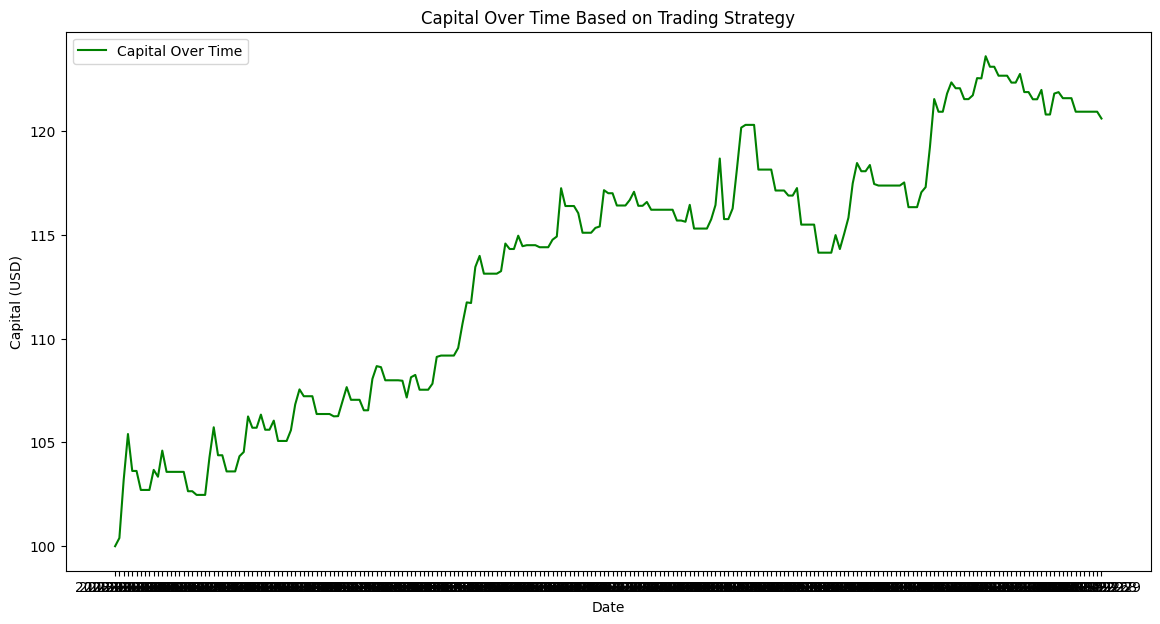

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
trading_fraction = 0.5  # درصد سرمایه برای معامله

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []

# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با 10٪ از سرمایه
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:
        # فروش 10٪ از سهام
        shares_sold = shares
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# نمایش سیگنال‌ها و سود هر روز
results_df['capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# buy and sell with fraction

Total Profit: 23.06 USD
             ds    y_actual  y_predicted signal     capital
0    2023-01-31  144.289993    140.42755    Buy  100.000000
1    2023-02-01  145.429993    143.24666    Buy  100.395038
2    2023-02-02  150.820007    145.26890    Buy  103.189374
3    2023-02-03  154.500000    149.06754    Buy  105.402186
4    2023-02-06  151.729996    153.91434   Sell  103.624503
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  123.424289
227  2023-12-26  193.050003    193.25229   Sell  123.397543
228  2023-12-27  193.149994    192.46585   Sell  123.399974
229  2023-12-28  193.580002    192.46298    Buy  123.405202
230  2023-12-29  192.529999    192.72406   Sell  123.064137

[231 rows x 5 columns]


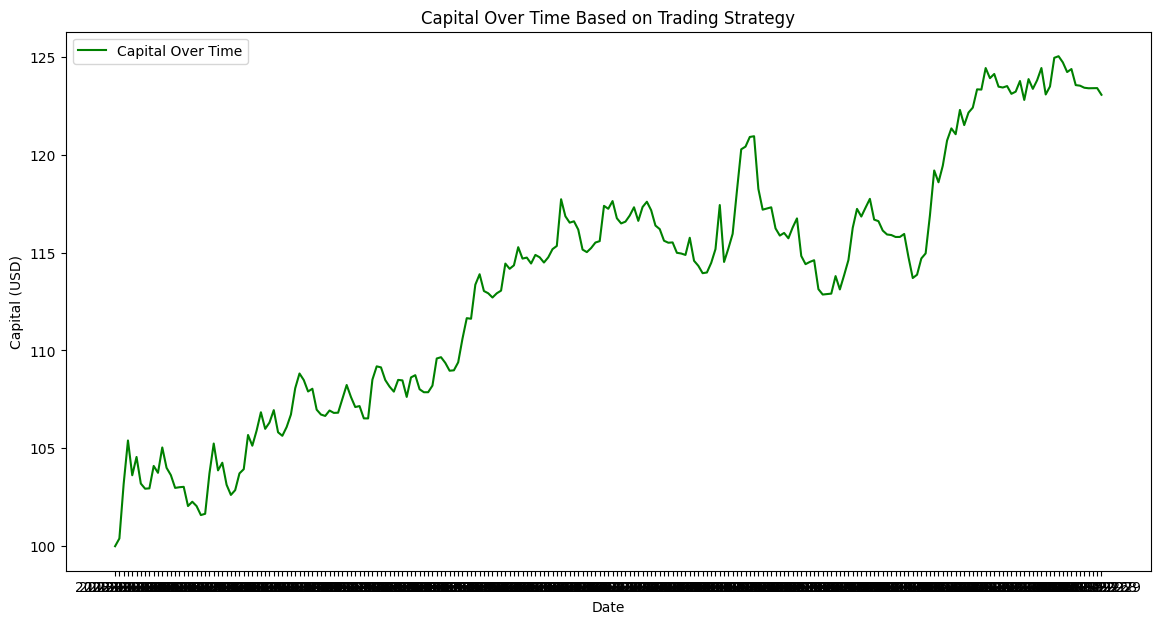

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
trading_fraction = 0.5 # درصد سرمایه برای معامله

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []

# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با 10٪ از سرمایه
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:
        # فروش 10٪ از سهام
        shares_sold = shares * trading_fraction
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# نمایش سیگنال‌ها و سود هر روز
results_df['capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# forecast 10 day by 30 day

In [ ]:


import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import timesfm
import numpy as np

# Fetch historical data for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Select the 'Close' price as the feature for forecasting
data = data[['Close']]

# Reset index to use the date in the DataFrame
data.reset_index(inplace=True)

# Rename columns to match expected format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'  # Add a unique_id column

# Initialize the model
tfm = timesfm.TimesFm(
    context_len=512,  # Maximum context length
    horizon_len=10,  # Forecasting the next 10 days
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',  # Or 'jax'
)

# Load the pretrained model
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Function to predict the next 10 days
def predict_next_days(train_data):
    forecast_df = tfm.forecast_on_df(
        inputs=train_data,
        freq="D",
        value_name="y",
        num_jobs=-1,
    )
    print("forecast_df",forecast_df)
    print("forecast_df.iloc[-1]['timesfm'] ",forecast_df.iloc[-1]['timesfm'] )
    return forecast_df.iloc[-1]['timesfm']  # Predict only the last day in the forecast horizon

# Splitting the data into rolling windows
start_date = '2023-01-01'
end_date = '2023-12-31'
window_size = 30
prediction_horizon = 10

results = []

date_range = pd.date_range(start=start_date, end=end_date)

for i in range(len(date_range) - window_size - prediction_horizon):
    train_window_start = date_range[i]
    train_window_end = date_range[i + window_size - 1]
    predict_date = date_range[i + window_size + prediction_horizon - 1]

    train_data = data[(data['ds'] >= train_window_start) & (data['ds'] <= train_window_end)]
    print('train_data',train_data)
    print('predict_date',predict_date)

    if predict_date not in data['ds'].values:
        print(f"Skipping prediction for {predict_date} as it's not in the data.")
        continue

    actual_value = data[data['ds'] == predict_date]['y'].values[0]

    predicted_value = predict_next_days(train_data)
    results.append({'ds': predict_date, 'y_actual': actual_value, 'y_predicted': predicted_value})


[*********************100%%**********************]  1 of 1 completed
<ipython-input-2-f1274745c1a2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
<ipython-input-2-f1274745c1a2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['unique_id'] = 'AAPL'  # Add a unique_id column
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your setti

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.43 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Streaming output truncated to the last 5000 lines.
924 2023-09-05  189.699997      AAPL
925 2023-09-06  182.910004      AAPL
926 2023-09-07  177.559998      AAPL
927 2023-09-08  178.179993      AAPL
928 2023-09-11  179.360001      AAPL
929 2023-09-12  176.300003      AAPL
predict_date 2023-09-22 00:00:00
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
forecast_df   unique_id         ds     timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0      AAPL 2023-09-13  178.269257     175.519989     176.532074   
1      AAPL 2023-09-14  180.502731     176.434921     177.816559   
2      AAPL 2023-09-15  181.539688     176.834457     178.295120   
3      AAPL 2023-09-16  180.516800     176.216187     177.647919   
4      AAPL 2023-09-17  178.053223     174.793289     175.695480   
5      AAPL 2023-09-18  176.141602     173.455109     174.420700   
6      AAPL 2023-09-19  174.825745     172.494629     173.408447   
7      AAPL 2023-09-20  174.997620  

In [ ]:

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV file
results_df.to_csv('prediction_results.csv', index=False)

print("Results saved to prediction_results.csv")


In [76]:
results_df= pd.read_csv('prediction_results.csv'
)

Overall Mean Squared Error: 75.60305753052835
Overall Mean Absolute Error: 7.2685798589433945


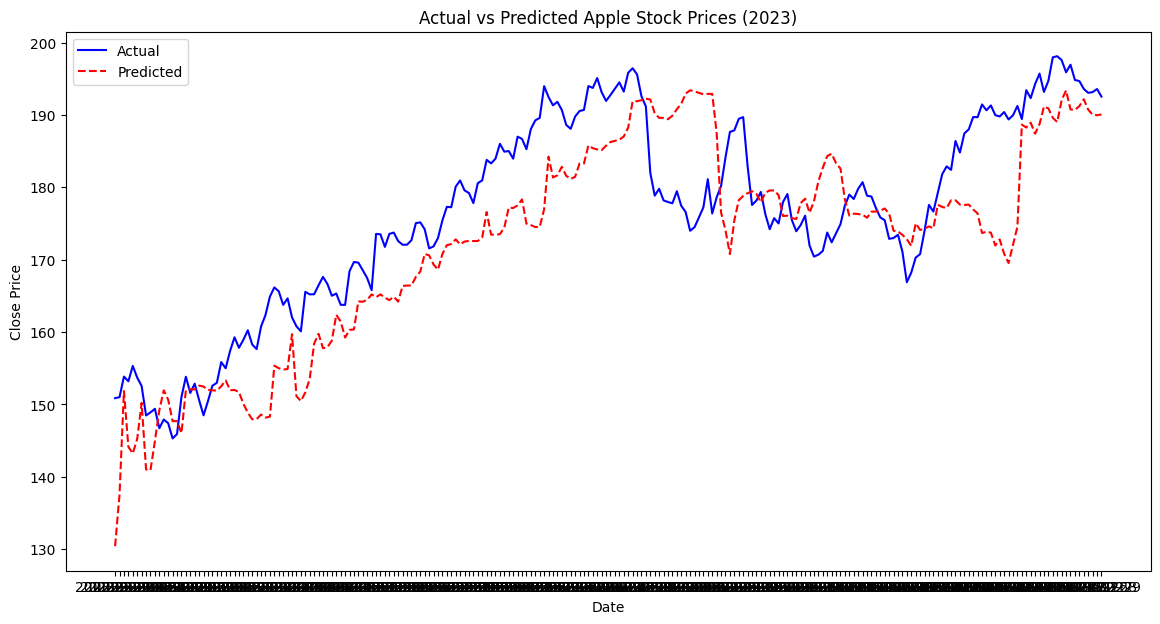

In [77]:

# Calculate overall accuracy
mse = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
mae = mean_absolute_error(results_df['y_actual'], results_df['y_predicted'])

print(f'Overall Mean Squared Error: {mse}')
print(f'Overall Mean Absolute Error: {mae}')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Apple Stock Prices (2023)')
plt.legend()
plt.show()

In [44]:


# Calculate movement accuracy
correct_predictions = 0
total_predictions = 0

for i in range(1, len(results_df)):
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['ds']

    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['ds']) - pd.DateOffset(days=1):
        continue

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday

    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.4685714285714286


Total Profit: 10.61 USD
             ds    y_actual  y_predicted signal     capital
0    2023-02-09  150.869995    130.41766    Buy  100.000000
1    2023-02-10  151.009995    137.53496    Buy  100.092795
2    2023-02-13  153.850006    151.85606   Sell  101.975218
3    2023-02-14  153.199997    144.14484   Sell  101.975218
4    2023-02-15  155.330002    143.23639    Buy  101.975218
..          ...         ...          ...    ...         ...
219  2023-12-22  193.600006    192.16331   Sell  111.210926
220  2023-12-26  193.050003    190.72974   Sell  111.210926
221  2023-12-27  193.149994    190.03569   Sell  111.210926
222  2023-12-28  193.580002    189.95183    Buy  111.210926
223  2023-12-29  192.529999    190.07504   Sell  110.607703

[224 rows x 5 columns]


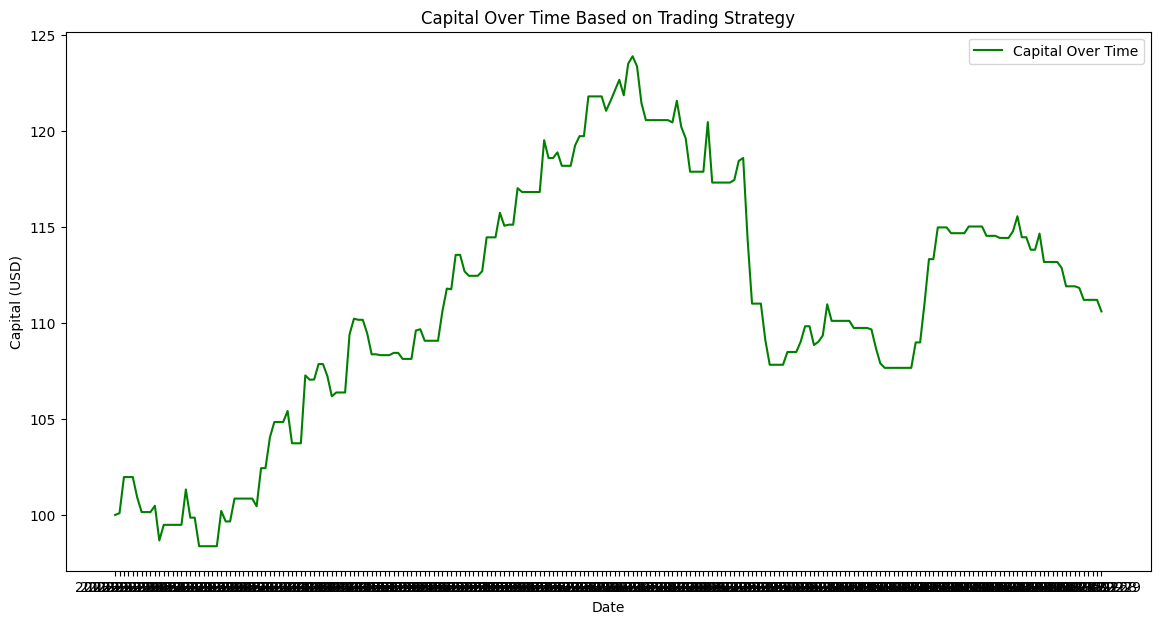

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []

# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()
